# Pandeia for WFIRST Integral Field Channel (IFC)

In this example we'll run a Pandeia calculation for one of the Integral Field Channel (IFC) baseline test cases described in Technical Report WFIRST-STScI-TR1701.

This Technical Report can be found at http://www.stsci.edu/files/live/sites/www/files/home/scientific-community/wfirst/_documents/WFIRST-STScI-TR1701.pdf

The figures within this technical report were produced by the code at https://github.com/spacetelescope/wfirst-ifc/tree/v20160223

## First, we need to import various python libraries ##

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from __future__ import print_function, division
import sys
import os
import numpy as np
import matplotlib
from matplotlib import style
from astropy.io import fits
#style.use('ggplot')  # see http://matplotlib.org/users/style_sheets.html
                     # for info on matplotlib styles
import json
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

# the first pandeia import is required to run calculations. the others are provided to
# allow setting up calculations and loading/saving of inputs or results.
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

## Next, we need to create a calculation ##

build_default_calc() takes three arguments: telescope, instrument, mode.  Telescope is (obviously) wfirst, instrument is wfirstifu, and the mode is ifu.

In [2]:
calc = build_default_calc('wfirst','wfirstifu','ifu')

## Next, we need to create a scene ##

We should now have a complete default calculation, now we'll edit our scene and observing parameters to match a typical supernova observing case (case 2 in TR1701).

We'll create a point source centered in the middle of the scene:

In [3]:
calc['scene'][0]['shape']['geometry'] = 'point' # default
calc['scene'][0]['position']['x_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['y_offset'] = 0.0 # arcsec

And we'll read in a spectrum of a redshift z=0.5 Type 1A supernova

In [4]:
filename=os.environ['pandeia_refdata']+'/wfirst/wfirstifu/tr1701/sources/waifs_sn1a_z0.5.fits'

In [5]:
d = (fits.open(filename))[1].data

In [6]:
wave=d['wavelength']

In [7]:
flux=d['flux']

Let's plot it quickly to see what the spectrum looks like

Text(0,0.5,'Flux (mJy)')

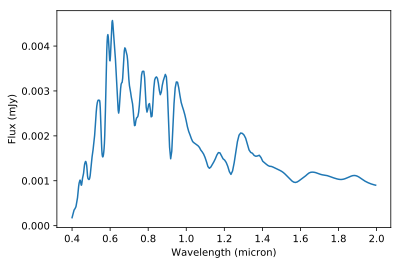

In [8]:
plt.plot(wave,flux)
plt.xlabel('Wavelength (micron)')
plt.ylabel('Flux (mJy)')

Let's put this spectrum into our scene for the point source

In [9]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = "input"
calc['scene'][0]['spectrum']['sed']['spectrum'] = [wave,flux]

We make sure to specify that the spectrum is already normalized to mJy units and doesn't need to be rescaled

In [10]:
calc['scene'][0]['spectrum']['normalization']['type']='none'

Following TR-1701, we'll assume a medium brightness zodiacal background signal:

In [11]:
calc['background']='medium'

And we'll use a fixed thermal background model instead of the default calculation:

In [12]:
thermal_filename=os.environ['pandeia_refdata']+'/wfirst/wfirstifu/tr1701/background/waifs_thermal.fits'

In [13]:
therm = (fits.open(thermal_filename))[1].data

In [14]:
calc['background']=[therm['wavelength'],therm['sb']]

## Now let's set up the instrument.

The WFIRST IFU Channel is similarly simple to configure.
The only valid filter is "clear", to be used with the "prism" disperser in the "ifu" aperture, and "full" subarray. You can select between 'nrs' (the default) and 'nrsrapid' readmodes.

(We are using JWST NIRSpec settings as placeholders for the WFIRST IFU detector settings.)

In [15]:
calc['configuration']['instrument']['filter'] = "clear"
calc['configuration']['instrument']['aperture'] = "ifu"
calc['configuration']['instrument']['disperser'] = "prism_tr1701" # Prism dispersion used for the TR
calc['configuration']['detector']['ngroup'] = 12 # groups per integration (11 in TR, with one to drop)
calc['configuration']['detector']['nint'] = 1 # integrations per exposures
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "nrs"
calc['configuration']['detector']['subarray'] = "full"

In this case we've chosen the 'nrs' readout mode, with 11 groups, 1 integration, and 1 exposure.  Note that this was described in TR1701 as 12 groups because that document assumed that one frame would be dropped.

## We can now set up the observing strategy. 


For WFIRST IFU, there are three different observing strategies:
    - 'ifuapphot': IFU Aperture Photometry. An IFU without dithers, which will be displayed in 2D as a slice of the resulting image cube (at the reference wavelength)
    - 'ifunodinscene': IFU Nod (in-scene) - the default. The same as the above, but with an dither smaller (generally <5 arcsec) than the FOV size.
    - 'ifunodoffscene': IFU Nod (off-scene). The same as the above, but the dither is larger (generally >10 arcsec) than the FOV size.
    
Note that Pandeia doesn't currently shift when it adds the dithers; this is a known limitation.

The ifuapphot method doesn't do any dithering:

In [16]:
calc['strategy']['method'] = 'ifuapphot'
calc['strategy']['aperture_size'] = 0.3 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.
if 'dithers' in calc['strategy'].keys():
    del calc['strategy']['dithers']

The ifunodinscene method assumes small on-source dithers:

In [17]:
calc['strategy']['method'] = 'ifunodinscene'
calc['strategy']['aperture_size'] = 0.3 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['dithers'] = [{'x':0.0,'y':0.0},{'x':1.0,'y':1.0}] # x,y offsets of dithers, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.

And ifunodoffscene assumes dedicated background observations:

In [18]:
calc['strategy']['method'] = 'ifunodoffscene'
calc['strategy']['aperture_size'] = 0.3 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['dithers'] = [{'x':0.0,'y':0.0},{'x':50.0,'y':0.0}] # x,y offsets of dithers, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.

For this notebook example we'll use the undithered aperture photometry, where we set the extraction location to match the source location, and use a 0.3 arcsec radius extraction aperture to match TR-1701

In [19]:
calc['strategy']['method'] = 'ifuapphot'
calc['strategy']['aperture_size'] = 0.3 # radius of extraction aperture, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] # x,y location to extract, in arcsec
calc['strategy']['reference_wavelength'] = None # Wavelength value (between 0.4 and 2.0 microns, non-inclusive) at which the 2D images and numerical outputs will be computed.
if 'dithers' in calc['strategy'].keys():
    del calc['strategy']['dithers']

In [20]:
calc['strategy']['sky_annulus']=[1.0,1.2] # sky annulus

## Now we do the calculation

We now have a formatted calculation we can run, so let's do that.

In [21]:
results = perform_calculation(calc)

Let's unpack the results.  The following gives the basic parameters - flux, SNR, exposure time, etc.

In [22]:
for x in results['scalar'].keys():
   print("{0:}:\t{1:}".format(x,results['scalar'][x]))

exposure_time:	520.87
aperture_size:	0.3
cr_ramp_rate:	0.0404893882629
reference_wavelength:	0.688748157892
extraction_area:	25.1327412287
all_dithers_time:	520.87
total_integrations:	1
saturation_time:	510.24
measurement_time:	467.72
sat_ngroups:	6443.0
sn:	5.62970860807
extracted_noise:	0.0656603670085
extracted_flux:	0.369648733357
duty_cycle:	0.897959183673
background:	4.159703782e-20
contamination:	1.0
fraction_saturation:	0.00186232870127
background_sky:	0.0
disperser:	prism_tr1701
filter:	clear
y_offset:	0.0
x_offset:	0.0
background_area:	122.87117934
background_total:	0.000936681407539
total_exposure_time:	520.87


Let's read in the reference results from TR1701:

In [23]:
tr1701_file=os.environ['pandeia_refdata']+'/wfirst/wfirstifu/tr1701/results/tr1701_case2.fits'

In [24]:
tr1701 = (fits.open(tr1701_file))[1].data

And now let's plot our new SNR results as a function of wavelength against the reference results:

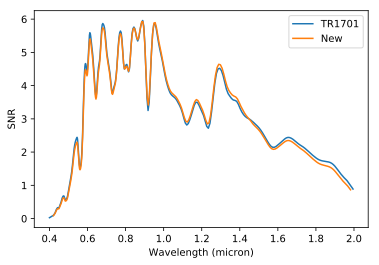

In [25]:
plt.plot(tr1701['wavelength'],tr1701['sn'])
plt.xlabel('Wavelength (micron)')
plt.ylabel('SNR')
plt.plot(results['1d']['sn'][0],results['1d']['sn'][1])
plt.legend(['TR1701', 'New'], loc='upper right')